In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from geomloss import SamplesLoss
from tqdm import tqdm

from utils import Synthetic
from differentiable_rendering.sigmoids_renderer.renderer import Renderer

In [3]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density


def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [15]:
s = Synthetic(64, 64)

np.random.seed(111)

image, lines = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

In [21]:
pixel_coords = compute_pixel_coords(image)
pixel_density = compute_pixel_density(image)

torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32))
torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32))

line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)
line_batch.requires_grad = True

loss = SamplesLoss("sinkhorn", p=2, blur=.01)

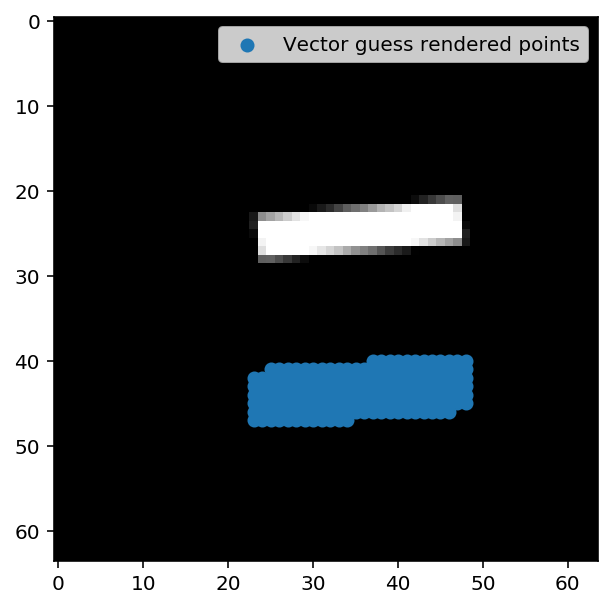

In [22]:
def visualize(renderer, image, line_batch, render_label):
    render = renderer.render(line_batch)[0].detach().cpu().numpy()
    x, y = np.nonzero(render)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gist_gray')
    plt.scatter(x, y, cmap='gist_gray', label=render_label)
    plt.legend()
    plt.show() 

renderer = Renderer((64, 64), linecaps='butt', dtype=torch.float32)
visualize(renderer, image, line_batch, 'Vector guess rendered points')

In [23]:
vector_coords = torch.from_numpy(np.mgrid[0:64, 0:64].reshape(2, -1).T.astype(np.float32))

raster_coords = torch_pixel_coords.clone()
raster_masses = torch_pixel_density.clone()

lr = 0.5

renderer = Renderer((64, 64), linecaps='butt', dtype=torch.float32)

for i in tqdm(range(50)):
    
    vector_masses = renderer.render(line_batch)[0]
    vector_masses = (vector_masses / vector_masses.sum()).flatten()
    
    if line_batch.grad is not None:
        line_batch.grad.data.zero_()

    sample_loss = loss(vector_masses, vector_coords, raster_masses, raster_coords)
    sample_loss.backward()
    
    g_line_batch = line_batch.grad.data
    line_batch.data -= lr * g_line_batch

100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


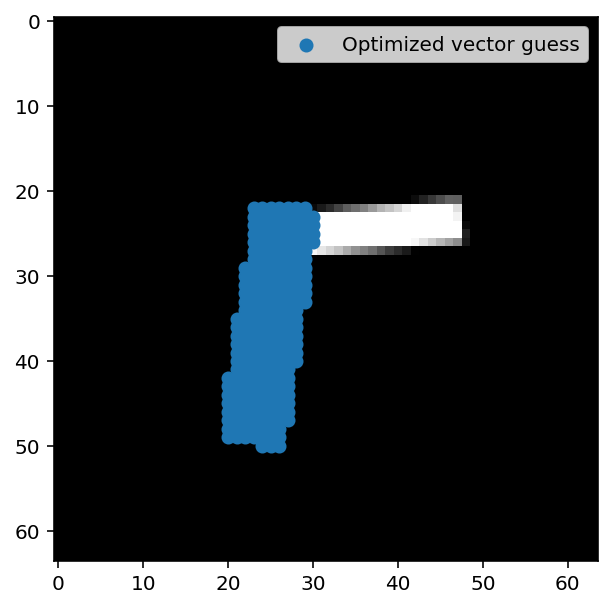

In [24]:
visualize(renderer, image, line_batch, 'Optimized vector guess')